# Experiment from July 2, 2015.
Structure of stimulus:  
22.5 min Low contrast binary white noise  
22.5 min High contrast binary white noise  
22.5 min Low contrast binary white noise  
22.5 min High contrast binary white noise  
90 min natural scenes  
10 min of 1 min repeating natural scenes  
5 min high contrast white noise

In [178]:
import numpy as np
from sklearn.decomposition import PCA
import scipy.io
import itertools
import os
import h5py
import pyret
import binary     # in igor >> recording

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt

# note that nonposx(y) for log plots will no longer work with this package
import mpld3
#mpld3.enable_notebook()

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Make animations play nicely in python notebook

In [39]:
from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)

from IPython.display import HTML

def display_animation(anim):
    close(anim._fig)
    return HTML(anim_to_html(anim))

# Choose data directory

In [2]:
data_dir = os.path.expanduser('~/Documents/Stanford/00 Baccus Lab/Data 2015_07_02/')

# Load photodiode  
To align stimulus and recording. The stimulus is briefly (<500ms) a grey screen, followed by a white photodiode for the first frame.

In [3]:
first_bin_file = data_dir + '150702a.bin'
raw_data = binary.readbin(first_bin_file, chanlist=[0])
header   = binary.readbinhdr(first_bin_file)

In [4]:
header['fs']

10000.0

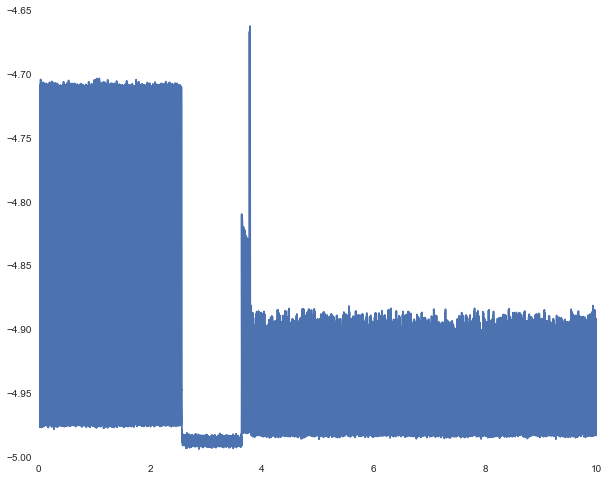

In [5]:
# show first 10 seconds
disp_frames = int(10 * header['fs'])
plot(np.linspace(0, 10, disp_frames), raw_data[:disp_frames])

/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


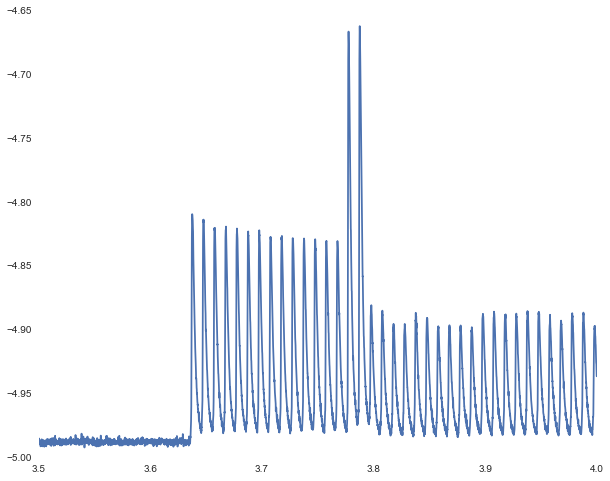

In [6]:
# show 3.5 to 4 seconds
disp_frames_start = 3.5 * header['fs']
disp_frames_end   = 4 * header['fs']
plot(np.linspace(3.5, 4, disp_frames_end - disp_frames_start), raw_data[disp_frames_start:disp_frames_end])

/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


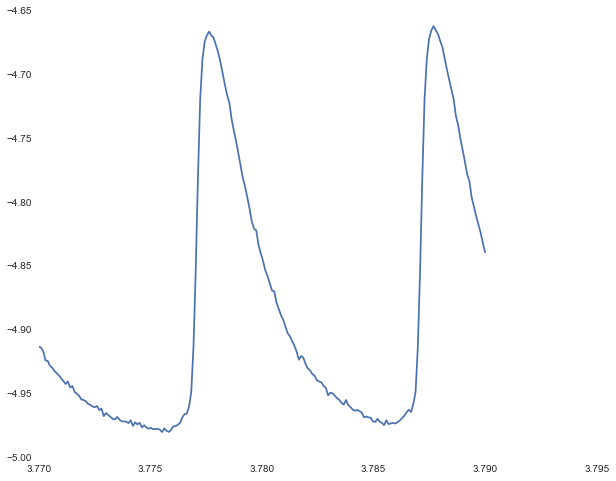

In [7]:
# show 3.77 to 3.79 seconds
disp_frames_start = 3.77 * header['fs']
disp_frames_end   = 3.79 * header['fs']
plot(np.linspace(3.77, 3.79, disp_frames_end - disp_frames_start), raw_data[disp_frames_start:disp_frames_end])

In [8]:
first_white_peak  = np.argmax(raw_data[3.77 * header['fs'] : 3.785 * header['fs']])
first_white_ind   = first_white_peak + 3.77 * header['fs']
time_stim_started = first_white_ind / header['fs']
print 'Stimulus started at %f seconds, relative to recording computer' %(time_stim_started)

Stimulus started at 3.777600 seconds, relative to recording computer


/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':
/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


# Load spikes

In [9]:
fs = sorted(os.listdir(data_dir))
fs = [f for f in fs if f.endswith(".txt")]

cells = []
for f in fs:
    text_file = open(data_dir + f, "r")
    spikes = text_file.read().split('\n')
    cells.append([float(spike) - time_stim_started for spike in spikes if (not (not spike)) and float(spike) - time_stim_started > 0])
    
    text_file.close()

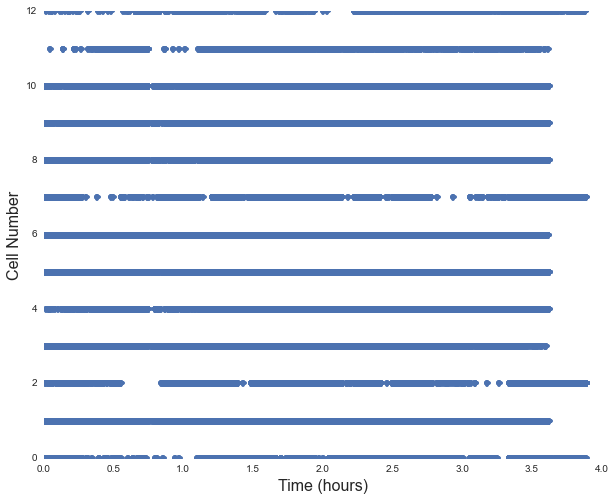

In [10]:
num_cells = len(cells)
all_spiking = np.hstack([ np.vstack((np.array(cell), np.ones(len(cell))*idx)) for idx, cell in enumerate(cells) ]).T
all_spiking.shape

plot(all_spiking[:,0]/(3600.), all_spiking[:,1], 'o')
xlabel('Time (hours)', fontsize=16)
ylabel('Cell Number', fontsize=16)

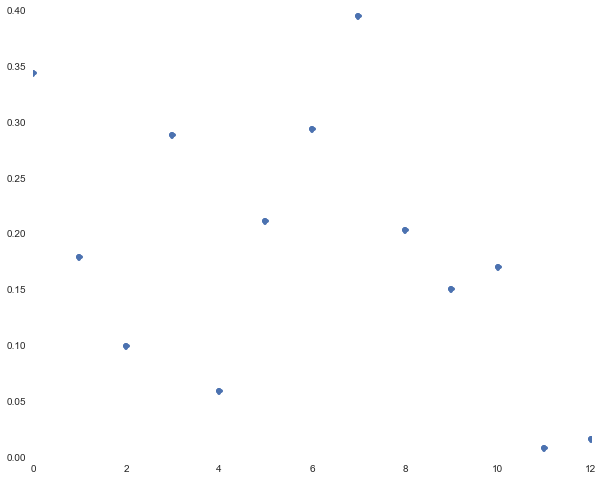

In [110]:
avg_spike_rate = [len(np.array(cells[i])[np.array(cells[i]) < 22.5*60.])/(22.5*60.) for i in range(len(cells))]
plot(avg_spike_rate, 'o')

# Load stimulus  
database is in format  
expt1/stim and expt1/timestamps  
for up to expt16

In [12]:
# stim_file = '/Volumes/data/Lane/2015-07-02/stimulus/stimulus.h5'
# stim_file = '/Volumes/LACIE DRIVE/Lane/2015_07_02/stimulus/stimulus.h5'
stim_file = os.path.expanduser('~/Documents/Stanford/00 Baccus Lab/Data 2015_07_02/stimulus.h5')
f = h5py.File(stim_file)

# Choose a cell  
Neuron 1 has a good high contrast RF

In [123]:
neuron = 8

# Low contrast

In [124]:
expt1_time = f['expt1/timestamps']
expt1 = np.array(f['expt1/stim'])
expt1 = np.rollaxis(expt1, 0, 3)
sta, sta_taxis = pyret.filtertools.getsta(expt1_time, expt1, cells[neuron], 30, norm=True)

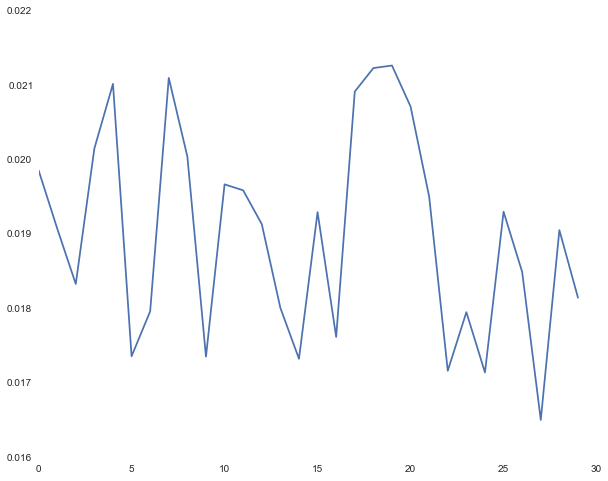

In [125]:
maxs = np.array([np.max(abs(sta[:,:,i])) for i in range(sta.shape[2])])
plot(maxs)

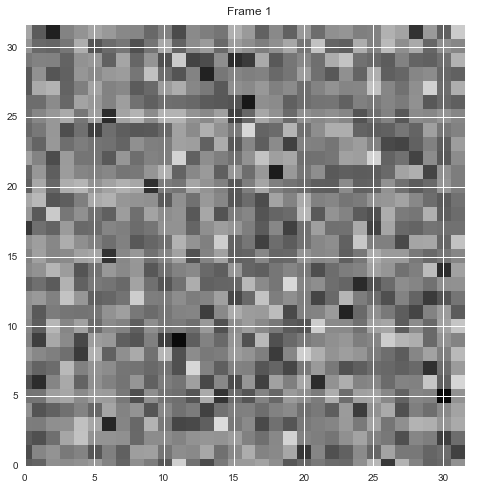

In [126]:
# First set up the figure, the axis, and the plot element we want to animate
# fig = figure()
# ax = axes(xlim=(0, 2), ylim=(-2, 2))
# line, = ax.plot([], [], lw=2)

anim = pyret.visualizations.playsta(sta, clim=[np.min(sta), np.max(sta)])
display_animation(anim)

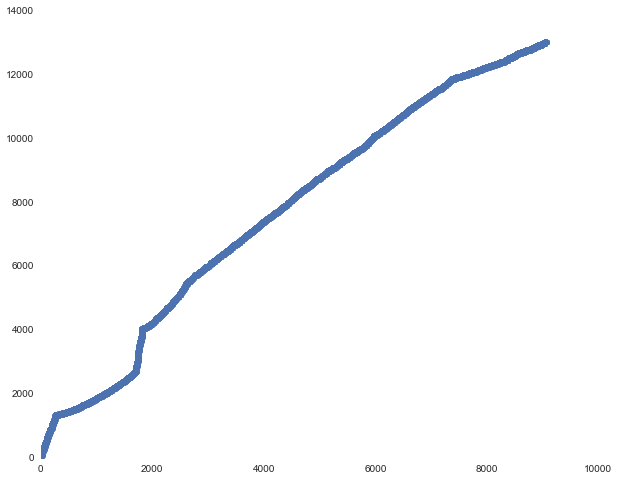

In [127]:
plot(cells[neuron], 'o')

In [128]:
np.max(cells[neuron])/(3600.)

3.6188845555555558

# High contrast

In [129]:
expt2_time = f['expt2/timestamps'] + f['expt1/timestamps'][-1] + f['expt1/timestamps'][1]
expt2 = np.array(f['expt2/stim']).T
sta, sta_taxis = pyret.filtertools.getsta(expt2_time, expt2, cells[neuron], 30, norm=True)

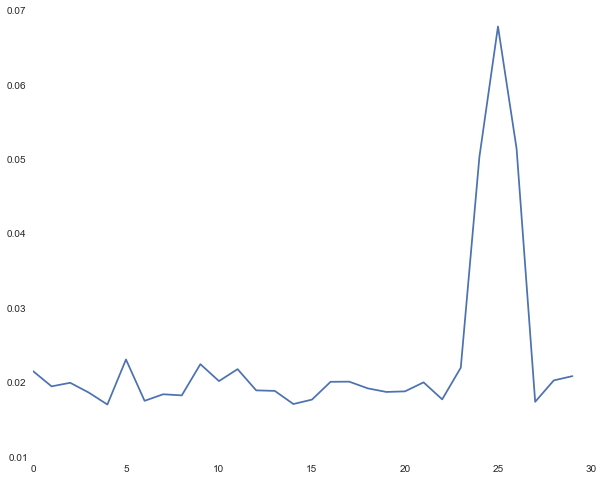

In [130]:
maxs = np.array([np.max(abs(sta[:,:,i])) for i in range(sta.shape[2])])
plot(maxs)

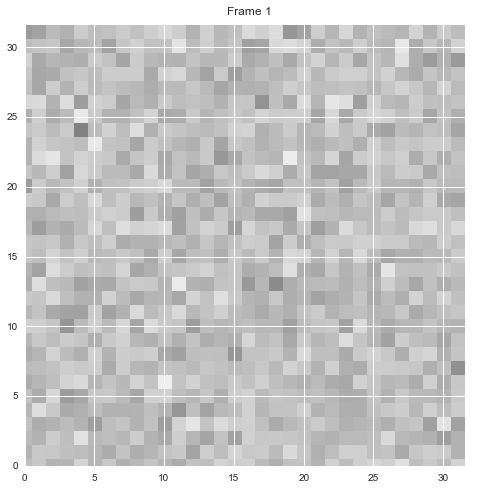

In [131]:
# First set up the figure, the axis, and the plot element we want to animate
# fig = figure()
# ax = axes(xlim=(0, 2), ylim=(-2, 2))
# line, = ax.plot([], [], lw=2)

anim = pyret.visualizations.playsta(sta, clim=[np.min(sta), np.max(sta)])
display_animation(anim)

In [132]:
high_contrast_pca = PCA(n_components=3)
high_contrast_pca.fit(np.sum(sta, axis=0).T)

PCA(copy=True, n_components=3, whiten=False)

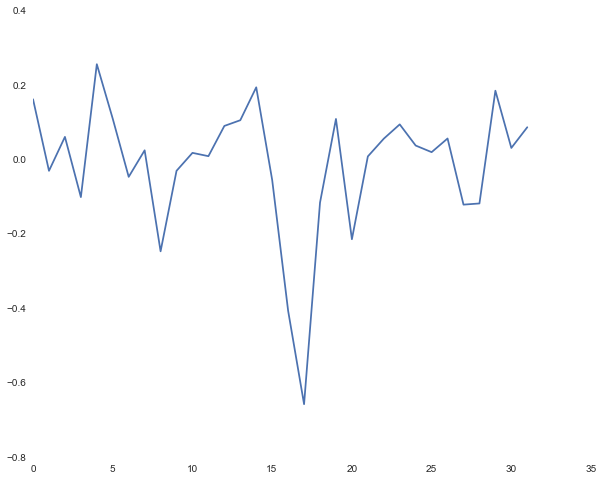

In [133]:
plot(high_contrast_pca.components_[0])

In [122]:
np.sum(sta, axis=0).shape

(32, 30)

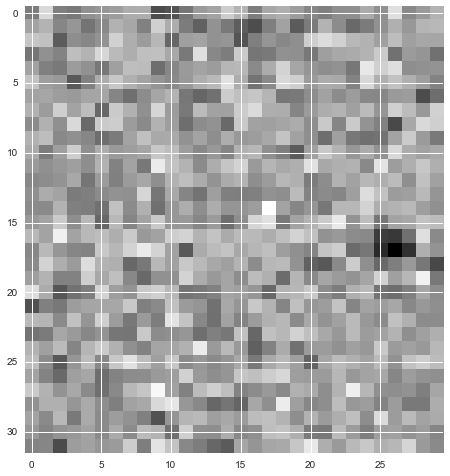

In [137]:
imshow(np.sum(sta, axis=0))

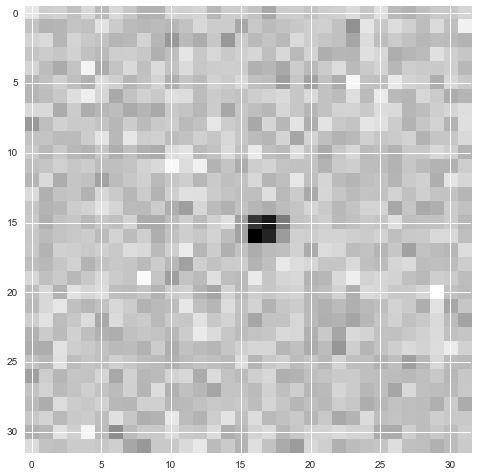

In [148]:
maxs = [np.max(np.abs(sta[:,:,i])) for i in range(sta.shape[2])]
imshow(sta[:,:,np.argmax(maxs)])

## Patch together both 22.5 minute stimuli segments

In [155]:
expt4_time = f['expt4/timestamps'] + f['expt1/timestamps'][-1] + f['expt2/timestamps'][-1] + \
                f['expt3/timestamps'][-1] + 3*f['expt1/timestamps'][1]
expt4 = np.array(f['expt4/stim']).T
sta, sta_taxis = pyret.filtertools.getsta(expt4_time, expt4, cells[neuron], 30, norm=True)

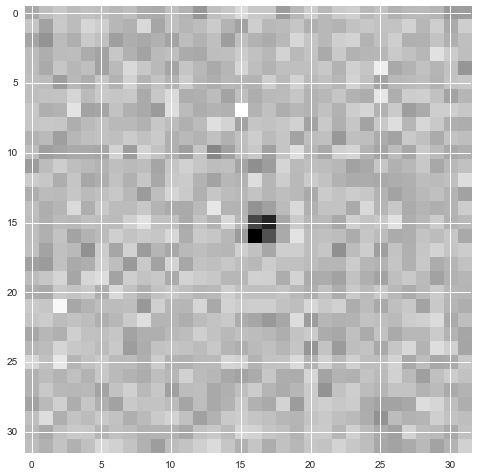

In [156]:
maxs = [np.max(np.abs(sta[:,:,i])) for i in range(sta.shape[2])]
imshow(sta[:,:,np.argmax(maxs)])

In [160]:
expt2.shape

(32, 32, 67459)

In [174]:
high_contrast_stim = np.append(expt2, expt4, axis=2)
high_contrast_time = np.append(expt2_time, expt4_time)

In [175]:
sta, sta_taxis = pyret.filtertools.getsta(high_contrast_time, high_contrast_stim, cells[neuron], 30, norm=True)

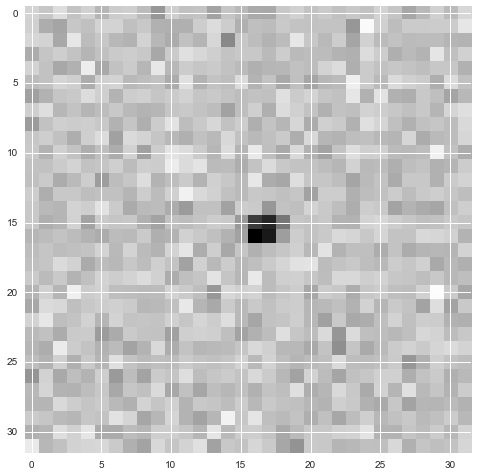

In [176]:
maxs = [np.max(np.abs(sta[:,:,i])) for i in range(sta.shape[2])]
img = imshow(sta[:,:,np.argmax(maxs)])
img.set_clim([np.min(sta), np.max(sta)])

## Patch together low contrast

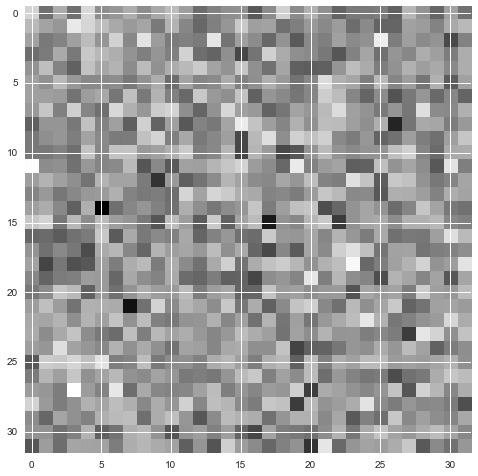

In [169]:
expt3_time = f['expt3/timestamps'] + f['expt1/timestamps'][-1] + f['expt2/timestamps'][-1] + \
                2*f['expt1/timestamps'][1]
expt3 = np.array(f['expt3/stim']).T
sta, sta_taxis = pyret.filtertools.getsta(expt3_time, expt3, cells[neuron], 30, norm=True)

maxs = [np.max(np.abs(sta[:,:,i])) for i in range(sta.shape[2])]
imshow(sta[:,:,np.argmax(maxs)])

In [170]:
low_contrast_stim = np.append(expt1, expt3, axis=2)
low_contrast_time = np.append(expt1_time, expt3_time)

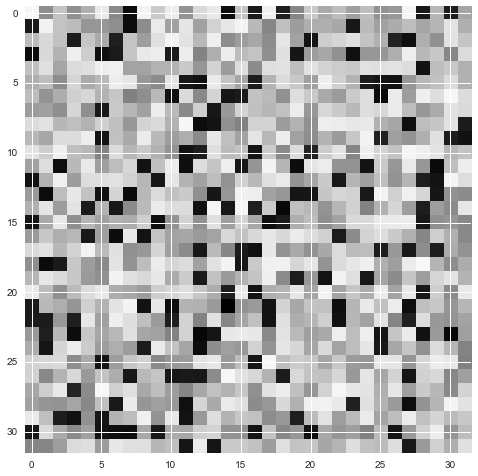

In [172]:
sta, sta_taxis = pyret.filtertools.getsta(low_contrast_time, low_contrast_stim, cells[neuron], 30, norm=True)
maxs = [np.max(np.abs(sta[:,:,i])) for i in range(sta.shape[2])]
img = imshow(sta[:,:,np.argmax(maxs)])
img.set_clim([np.min(sta), np.max(sta)])

# Plot all of the high contrast and low contrast RFs for each cell

In [185]:
? fig.set_size_inches

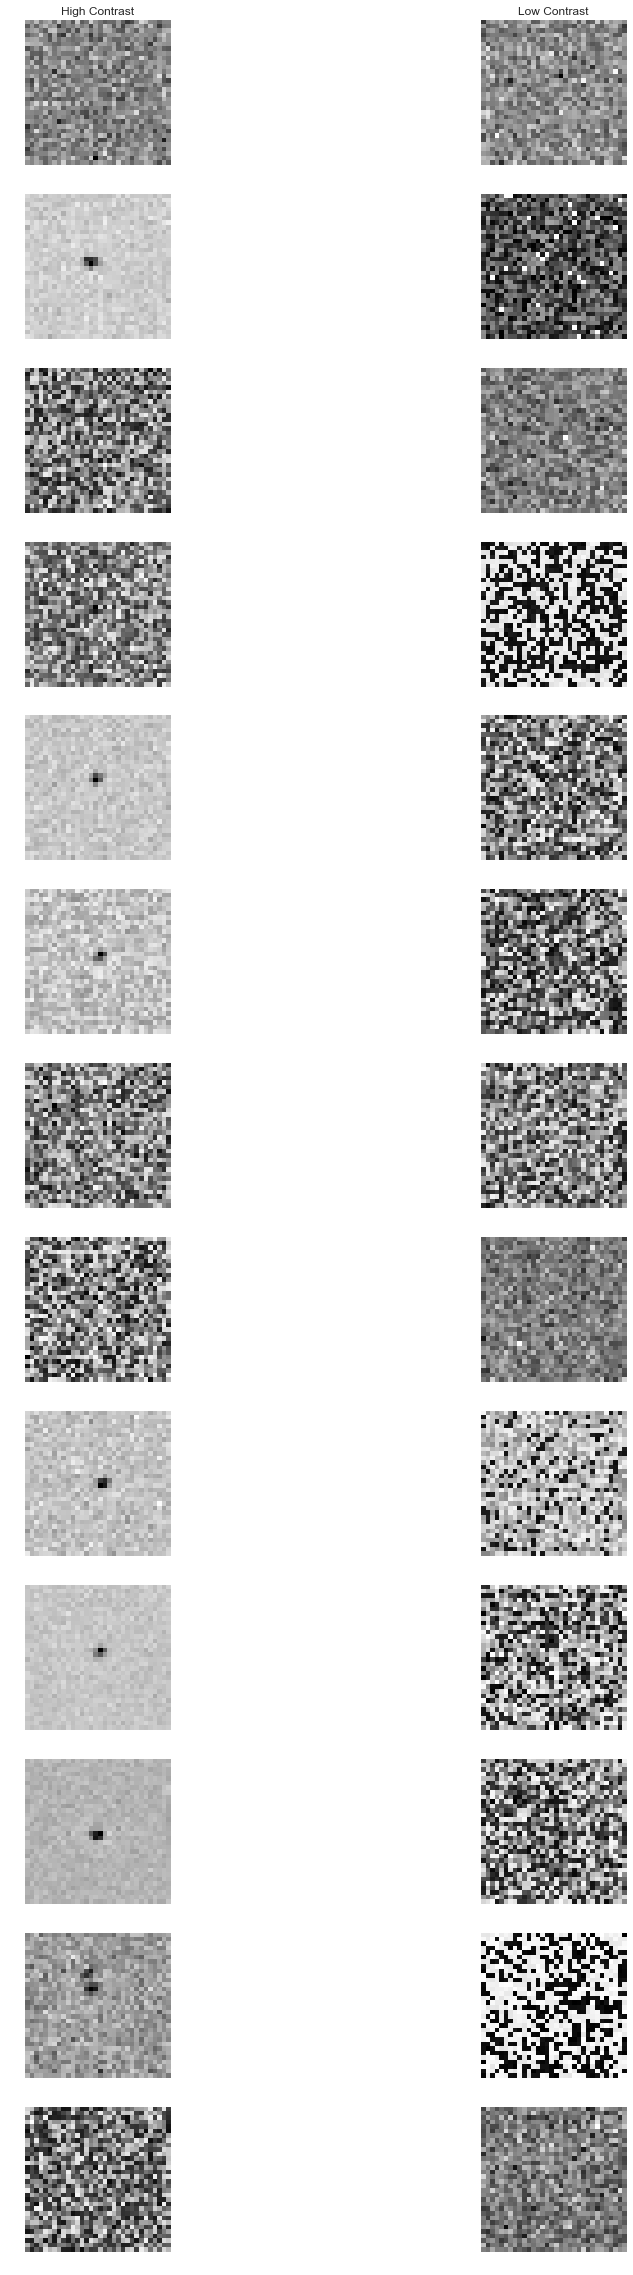

In [186]:
# Visualize the ganglion cell RFs under low and high contrast stimuli.
fig = gcf()
fig.set_size_inches((15, 40))

num_cols = 2
num_rows = num_cells
idxs = range(num_cols)
for y in range(num_cols):
    for i in range(num_rows):
        neuron = i
        plt_idx = i * num_cols + y + 1
        subplot(num_rows, num_cols, plt_idx)
        
        if y == 0:
            # high contrast
            sta_high, sta_taxis = pyret.filtertools.getsta(high_contrast_time, high_contrast_stim, cells[neuron], 30, norm=True)
            maxs_high = [np.max(np.abs(sta_high[:,:,idx])) for idx in range(sta_high.shape[2])]
            img = imshow(sta_high[:,:,np.argmax(maxs_high)])
            img.set_clim([np.min(sta_high), np.max(sta_high)])
        else:
            # low contrast
            sta_low, sta_taxis = pyret.filtertools.getsta(low_contrast_time, low_contrast_stim, cells[neuron], 30, norm=True)
            maxs_low = [np.max(np.abs(sta_low[:,:,idx])) for idx in range(sta_low.shape[2])]
            img = imshow(sta_low[:,:,np.argmax(maxs_low)])
            img.set_clim([np.min(sta_low), np.max(sta_low)])
            
        plt.axis('off')
        if i == 0:
            if y == 0:
                plt.title('High Contrast')
            else:
                plt.title('Low Contrast')